In [61]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns

In [62]:
from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

In [63]:
def make_fn(case, v_x, v_y, comment=''):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'dist_plots_f09_f09_allyears_OA_{comment}_{case}_{_x}_{_y}.png'
    return plot_path /f



In [64]:
plot_path = Path('Plots')

In [65]:
xr.set_options(keep_attrs=True) 

## Get observational data

In [66]:
import pandas as pd

In [67]:
from bs_fdbck.constants import measurements_path

In [68]:
fn = measurements_path /'SourceData_Yli_Juuti2021.xls'

df_hyy_1 = pd.read_excel(fn, sheet_name=4, header=1,)# usecols=range(7,12),nrows=7)

df_hyy_1.head()
#df_hyy_1y= df_hyy_1y.rename({'year.1':'year',
#                            'T (degree C).1':'T (degree C)',
#                             'OA (microgram m^-3).1':'OA (microgram m^-3)',
#                             'N100 (cm^-3).1':'N100 (cm^-3)'
#                            }, axis=1)
#df_hyy_1y['year'] = pd.to_datetime(df_hyy_1y['year'].apply(x:str(x)))

df_hyy_1

,year,month,day,LAT,LON,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
0,2012,7,5,60.5,22.5,3.218589,191,12.940000,26.219999
1,2012,7,10,60.5,22.5,4.714353,172,10.950000,24.430000
2,2012,7,14,60.5,22.5,1.451827,106,15.790000,12.030000
3,2012,7,19,60.5,22.5,3.101941,262,16.039999,28.650000
4,2012,7,22,60.5,22.5,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
3668,2018,8,13,65.5,29.5,0.674785,191,15.200000,18.969999
3669,2018,8,14,65.5,29.5,1.356364,291,15.200000,31.449999
3670,2018,8,19,65.5,29.5,0.916047,139,18.230000,11.960000
3671,2018,8,20,65.5,29.5,1.325436,177,14.049999,19.869999


In [69]:
import pandas as pd

In [70]:
df_hyy_1['date'] = df_hyy_1.apply(lambda x: f'{x.year:.0f}-{x.month:02.0f}-{x.day:02.0f}', axis=1)

df_hyy_1['date'] = pd.to_datetime(df_hyy_1['date'] )

In [71]:
df_hyy_1 = df_hyy_1.set_index(['date','LAT','LON'])

In [72]:
df_hyy_1

,,,year,month,day,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
date,LAT,LON,,,,,,,
2012-07-05,60.5,22.5,2012,7,5,3.218589,191,12.940000,26.219999
2012-07-10,60.5,22.5,2012,7,10,4.714353,172,10.950000,24.430000
2012-07-14,60.5,22.5,2012,7,14,1.451827,106,15.790000,12.030000
2012-07-19,60.5,22.5,2012,7,19,3.101941,262,16.039999,28.650000
2012-07-22,60.5,22.5,2012,7,22,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
2018-08-13,65.5,29.5,2018,8,13,0.674785,191,15.200000,18.969999
2018-08-14,65.5,29.5,2018,8,14,1.356364,291,15.200000,31.449999
2018-08-19,65.5,29.5,2018,8,19,0.916047,139,18.230000,11.960000


In [73]:
#df_hyy_1['OA_category']

df_hyy_1['OA_low'] = df_hyy_1['OA (microgram m^-3)']<2
df_hyy_1['OA_high']= df_hyy_1['OA (microgram m^-3)']>2
ddf_hyy_1=df_hyy_1.assign(OA_category= pd.NA)
df_hyy_1.loc[df_hyy_1['OA_high'], 'OA_category'] = 'OA high'
df_hyy_1.loc[df_hyy_1['OA_low'], 'OA_category'] = 'OA low'



In [74]:
bins = pd.IntervalIndex.from_tuples([(60, 100), (100, 140), (140, 180), (180, 220), (220, 260), (260, 300), (300, 340)])

In [75]:
labels=[ 80, 120, 160, 200, 240, 280, 320]

In [76]:
df_hyy_1['CWP_cut']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins, labels=labels)
df_hyy_1['CWP_qcut']=pd.qcut(df_hyy_1['CWP (g m^-2)'], 6)#bins=bins, labels=labels)

In [77]:
df_hyy_1['CWP_qcutl'] = df_hyy_1['CWP_qcut'].apply(lambda x:x.mid)

df_hyy_1['CWP_cutl'] = df_hyy_1['CWP_cut'].apply(lambda x:x.mid)

<AxesSubplot:ylabel='Frequency'>

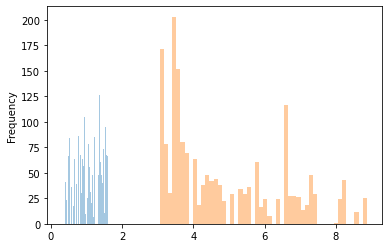

In [78]:
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_high']].plot.hist(bins=50, alpha=0.4, label='obs')



## Get model data:

In [79]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA'

In [80]:
models =[model_name_noresm]

### Settings

In [81]:
lon_lims = [22.,30.]
lat_lims = [60.,66.]

lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

In [82]:
temperature = 273.15  # K


from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

### NorEMS

In [83]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files

In [84]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1_final_long_summer.csv'

In [85]:

cases_noresm = [case_name_noresm]

#### Station variables

In [86]:
varl_st_noresm = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3',
                 ]


varl_cl_noresm = ['TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP','TGCLDLWP','TGCLDIWP',
           'TOT_CLD_VISTAU_s','TOT_ICLD_VISTAU_s','optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL','ACTNL','TGCLDLWP',
           'FSDSC','FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC','FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

### ECHAM-SALSA

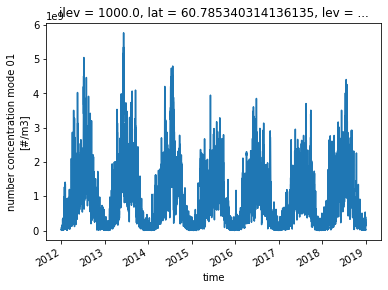

In [87]:
ds_mod = xr.open_dataset(fn_noresm, chunks = {'time':48})
ds_mod['NCONC01'].isel(lat=0, lon=0).plot()

## If file createad already, skip to here

### Select hyytiala grid cell:

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [88]:

ds_all = xr.open_dataset(fn_noresm)



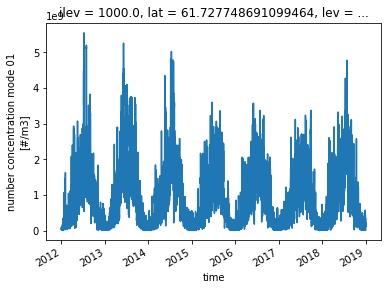

In [89]:
ds_all['NCONC01'].isel(lat=1, lon=1).plot()

In [90]:
dic_ds = dict()
dic_ds[model_name_noresm] =ds_all

In [91]:
df_mod = pd.read_csv(fn_noresm_csv, index_col=[0,1,2] )
dic_df = dict()
dic_df[model_name_noresm] = df_mod

In [92]:
df_mod

NMR13  nscur  hybm   T  EC550AER  FLNS  FSNS  DER  \
time       lat       lon                                                        
2012-01-02 60.785340 22.50    NaN    NaN   NaN NaN       NaN   NaN   NaN  NaN   
                     23.75    NaN    NaN   NaN NaN       NaN   NaN   NaN  NaN   
                     25.00    NaN    NaN   NaN NaN       NaN   NaN   NaN  NaN   
                     26.25    NaN    NaN   NaN NaN       NaN   NaN   NaN  NaN   
                     27.50    NaN    NaN   NaN NaN       NaN   NaN   NaN  NaN   
...                           ...    ...   ...  ..       ...   ...   ...  ...   
2018-12-31 65.497382 25.00    NaN    NaN   NaN NaN       NaN   NaN   NaN  NaN   
                     26.25    NaN    NaN   NaN NaN       NaN   NaN   NaN  NaN   
                     27.50    NaN    NaN   NaN NaN       NaN   NaN   NaN  NaN   
                     28.75    NaN    NaN   NaN NaN       NaN   NaN   NaN  NaN   
                     30.00    NaN    NaN   NaN NaN       NaN   NaN   NaN  NaN   

                            CCN3  SFisoprene  ...  ismonth7  ismonth8  \
time       lat       lon                      ...                       
2012-01-02 60.785340 22.50   NaN         NaN  ...       NaN       NaN   
                     23.75   NaN         NaN  ...       NaN       NaN   
                     25.00   NaN         NaN  ...       NaN       NaN   
                     26.25   NaN         NaN  ...       NaN       NaN   
                     27.50   NaN         NaN  ...       NaN       NaN   
...                          ...         ...  ...       ...       ...   
2018-12-31 65.497382 25.00   NaN         NaN  ...       NaN       NaN   
                     26.25   NaN         NaN  ...       NaN       NaN   
                     27.50   NaN         NaN  ...       NaN       NaN   
                     28.75   NaN         NaN  ...       NaN       NaN   
                     30.00   NaN         NaN  ...       NaN       NaN   

                            ismonth9  isJuly  isAug  isJA  isSummer    ilev  \
time       lat       lon                                                      
2012-01-02 60.785340 22.50       NaN     NaN    NaN   NaN       NaN  1000.0   
                     23.75       NaN     NaN    NaN   NaN       NaN  1000.0   
                     25.00       NaN     NaN    NaN   NaN       NaN  1000.0   
                     26.25       NaN     NaN    NaN   NaN       NaN  1000.0   
                     27.50       NaN     NaN    NaN   NaN       NaN  1000.0   
...                              ...     ...    ...   ...       ...     ...   
2018-12-31 65.497382 25.00       NaN     NaN    NaN   NaN       NaN  1000.0   
                     26.25       NaN     NaN    NaN   NaN       NaN  1000.0   
                     27.50       NaN     NaN    NaN   NaN       NaN  1000.0   
                     28.75       NaN     NaN    NaN   NaN       NaN  1000.0   
                     30.00       NaN     NaN    NaN   NaN       NaN  1000.0   

                                   lev  year  
time       lat       lon                      
2012-01-02 60.785340 22.50  992.556095  2012  
                     23.75  992.556095  2012  
                     25.00  992.556095  2012  
                     26.25  992.556095  2012  
                     27.50  992.556095  2012  
...                                ...   ...  
2018-12-31 65.497382 25.00  992.556095  2018  
                     26.25  992.556095  2018  
                     27.50  992.556095  2018  
                     28.75  992.556095  2018  
                     30.00  992.556095  2018  

[107352 rows x 203 columns]

df_modean data:

### Remove gridcells that don't have a lot of cloud?

<AxesSubplot:xlabel='TGCLDCWP', ylabel='CWP'>

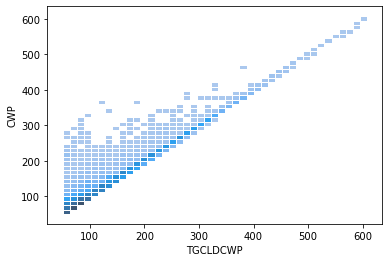

In [93]:
v_x = 'TGCLDCWP'
#ax = axs[1]
df_mod = dic_df[model_name_noresm]

_df = (df_mod[df_mod[v_x].notnull()])#[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]>50]
_df = _df[_df[v_x]<10000]
sns.histplot(
    x=v_x,
    y= 'CWP',
    data=_df,
    #hue=v_hue,
    #hue_order=hue_order,
    #ax = ax,
    legend=False,
    palette = 'Set1',
    edgecolor='w',
)

### Remove grid vells with no cloud top liquid

More than 10% cloud top liquid fraction in grid cell and 90% of the cloud fraction is covered by liquid. 

In [94]:
mask_liq_cloudtop = (df_mod['FCTL']>0.1) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop

## Cloud water path above 50

In [95]:
rn_dic_echam = {
    'cwp'      : 'CWP',
    'cod'      : 'COT',
    'ceff_ct'  : 'r_eff',


}
rn_dic_noresm = {
    'TGCLDCWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',

}



In [96]:
dic_df['Observations'] = df_hyy_1#.keys()

In [97]:
for key, rn in zip([model_name_noresm,'Observations'], [rn_dic_noresm, rn_dic_obs]):
    dic_df[key] = dic_df[key].rename(rn, axis=1)

## Group by cloud water path

In [98]:
df_mod['CWP_qcut']=pd.qcut(df_mod['TGCLDCWP'],6)# bins=bins, labels=labels)§

In [99]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

In [100]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])

In [101]:
df_mod = dic_df[model_name_noresm]

v = 'CLDFREE'
df_mod[v].quantile(.99)

0.48497747080000003

In [102]:
df_mod[v].mean()

0.033812260250004805

In [103]:
df_mod[v].max()

0.7331621

In [104]:
df_mod[v].min()

0.0

In [105]:
for model_name in models:
    df_mod = dic_df[model_name]
    # Optical thickness > 50:
    df_mod = df_mod[df_mod['CWP']>=50]

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    df_mod['OA_low'] = df_mod['OA']<df_mod['OA'].quantile(.34)
    df_mod['OA_high']= df_mod['OA']>df_mod['OA'].quantile(.66)
    mid_range = ( df_mod['OA'].quantile(.34)<df_mod['OA']) & (df_mod['OA']<df_mod['OA'].quantile(.66))
    df_mod['OA_mid_range'] = mid_range
    df_mod=df_mod.assign(OA_category= pd.NA)
    df_mod.loc[df_mod['OA_high'], 'OA_category'] = 'OA high'
    df_mod.loc[df_mod['OA_low'], 'OA_category'] = 'OA low'

    dic_df[model_name] = df_mod

for model_name in [model_name_noresm]:
    df_mod = dic_df[model_name]
    v = 'CLDFREE'
    df_mod[f'{v}_low'] = df_mod[v]<df_mod[v].quantile(.34)
    df_mod[f'{v}_high']= df_mod[v]>df_mod[v].quantile(.66)
    mid_range = ( df_mod[v].quantile(.34)<df_mod[v]) & (df_mod[v]<df_mod[v].quantile(.66))
    df_mod[f'{v}_mid_range'] = mid_range
    df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
    df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
    df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'
    dic_df[model_name] = df_mod



/tmp/ipykernel_26266/2847529916.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)
/tmp/ipykernel_26266/2847529916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
/tmp/ipykernel_26266/2847529916.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

## Distribution plots:

In [106]:
palette = 'Set2'

In [107]:
import numpy as np

In [108]:
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [109]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

In [110]:
palette_OA = cmap_list[0:2]

3673


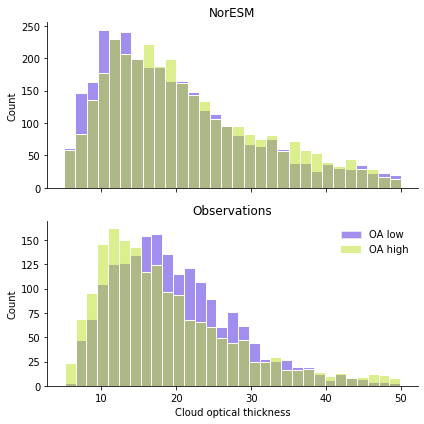

In [111]:
fig, axs = plt.subplots(2,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()

3673


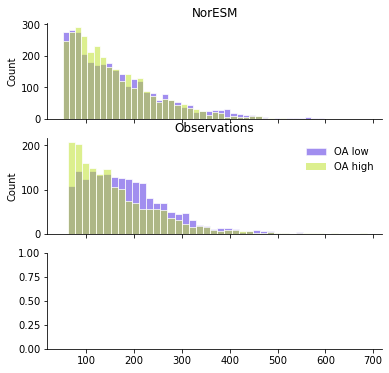

In [112]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6])

v_x = 'CWP'
x_cut = 700
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn(model_name_noresm, v_x,'obs',comment='distribution')

fig.savefig(fn, dpi=150)



3673
6225


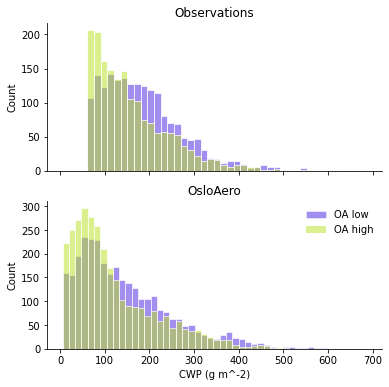

In [113]:
fig, axs = plt.subplots(2,1, sharex=True, figsize =[6,6])
v_x = 'CWP (g m^-2)'
x_cut = 10e10
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


_df = df_hyy_1
_df = _df[_df[v_x]<x_cut]

ax = axs[0]
sns.histplot(
    x=v_x,
    data=_df,
    hue=v_hue,
    hue_order=hue_order,
    palette=_palette,
    legend=False,
    edgecolor='w',
    ax = ax
)
print(len(_df))
ax.set_title('Observations')


v_x = 'TGCLDCWP'
ax = axs[1]

_df = (df_mod[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]<x_cut]
sns.histplot(
    x=v_x,
    data=_df,
    hue=v_hue,
    hue_order=hue_order,
    ax = ax,
    legend=False,
    palette = _palette,
    edgecolor='w',
)

ax.set_title('OsloAero')

custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('CWP (g m^-2)')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn(model_name + case_name_noresm, v_x,'obs',comment='distribution')

fig.savefig(fn, dpi=150)



### Fractional occurance of cloud top liquid

6225


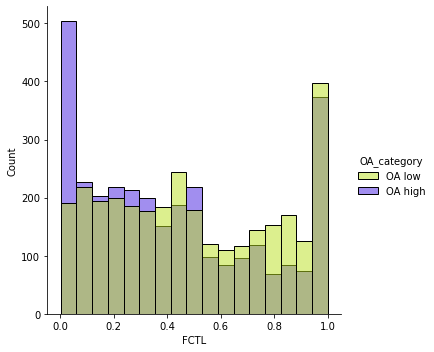

In [114]:
_df = df_mod#[(df_mod['OA_category'].notna()) & (df_mod['TOT_ICLD_VISTAU_s']>1)])
_df = _df#[_df['TGCLDCWP']<700]
sns.displot(#x='TGCLDLWP',
            x='FCTL',
            data=_df,
            hue='OA_category',
    palette=palette_OA,
           #kind='swarm'
           )
#plt.ylim([0,250])
print(len(df_mod[df_mod['OA_category'].notna()]))

### Take only points where 30% of cloud top is liquid

6225


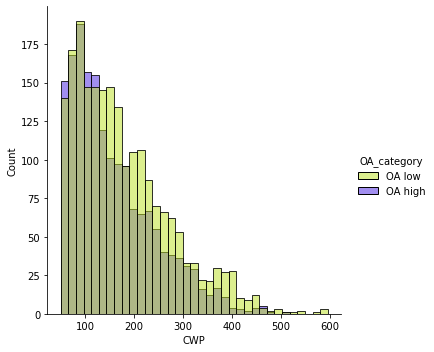

In [115]:
_df = df_mod
_df = _df[_df['FCTL']>.3]
sns.displot(
    x='CWP',
    data=_df,
    hue='OA_category',
    palette=palette_OA,
)
print(len(df_mod[df_mod['OA_category'].notna()]))

6236


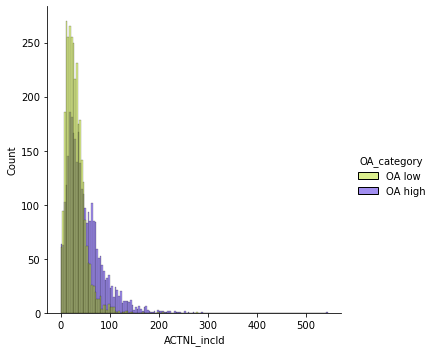

In [116]:
sns.displot(
    x='ACTNL_incld',
    data=df_mod[~df_mod['OA_mid_range']].reset_index(),
    hue='OA_category',
    palette=palette_OA,
)
print(len(df_mod[~df_mod['OA_mid_range']]))

## Cloud optical thickness

### Incloud

In [117]:
hue_order = ['OA low','OA high']
palette_OA_2 = palette_OA[::-1]

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 57.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 44.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


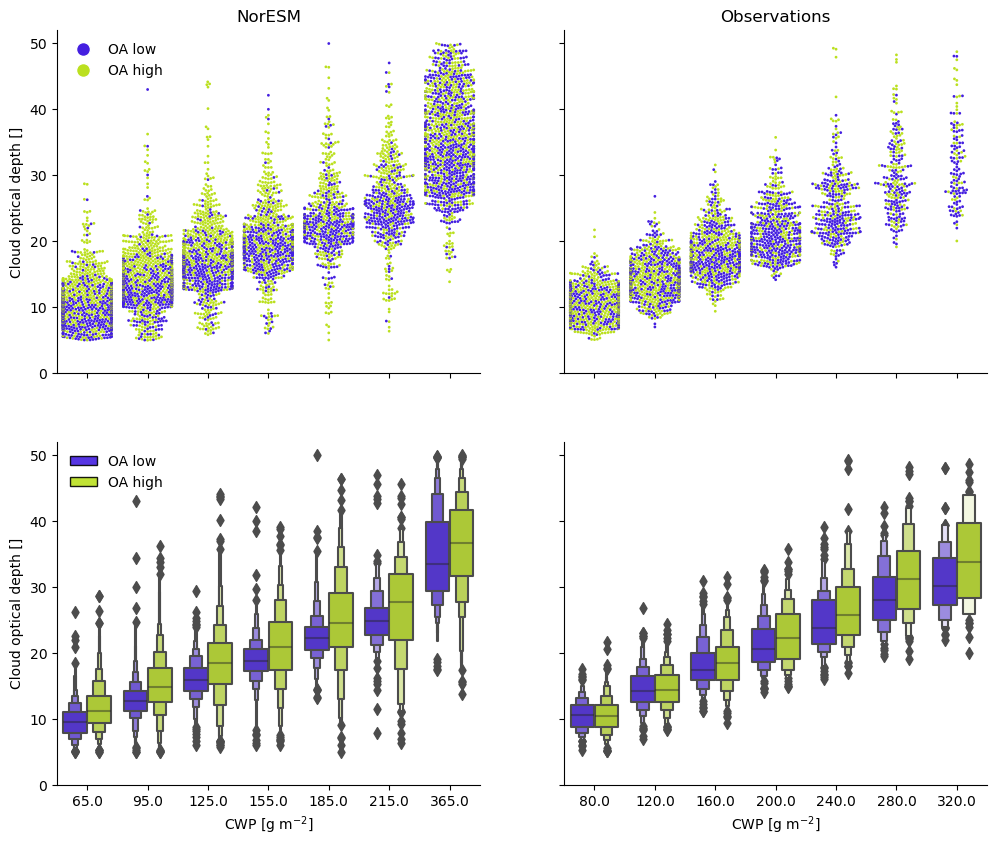

In [118]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [12,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(dic_df.keys(), axs[0,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(dic_df.keys(), axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

fn = make_fn('noresm_only', x_var,y_var, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 36.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


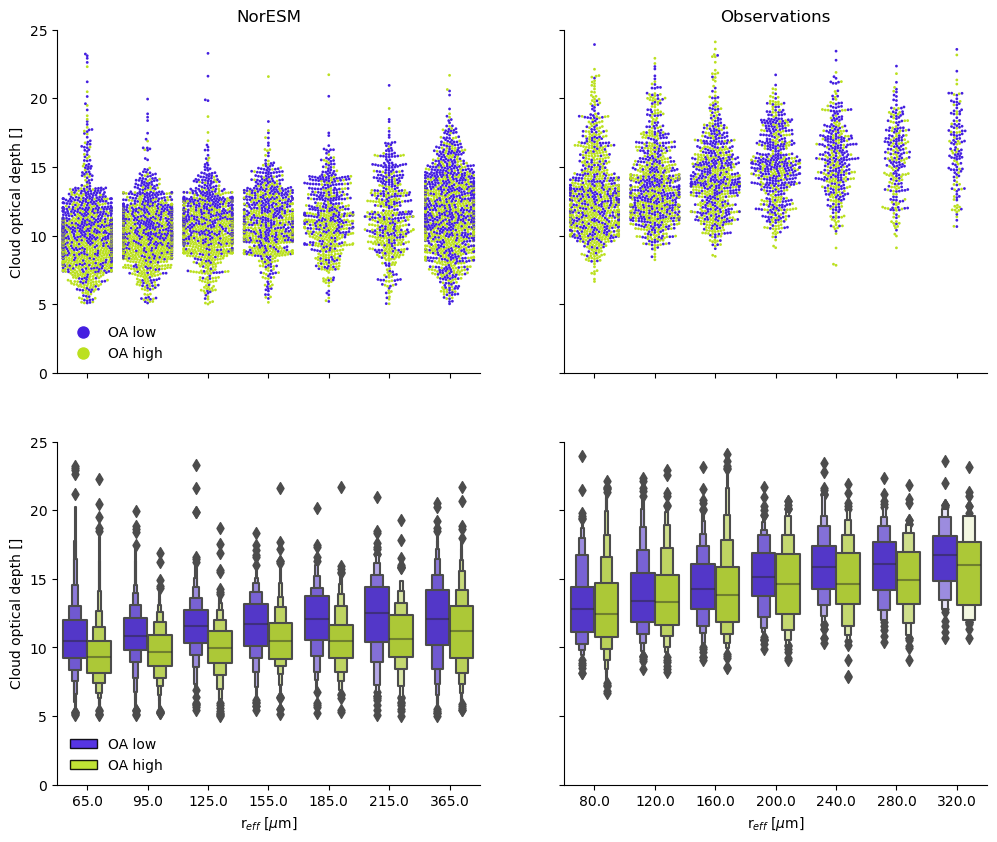

In [119]:
x_var = 'CWP_cutl'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [12,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(dic_df.keys(), axs[0,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(dic_df.keys(), axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('r$_{eff}$ [$\mu$m]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

fn = make_fn('noresm_only', x_var,y_var, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 65.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 54.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


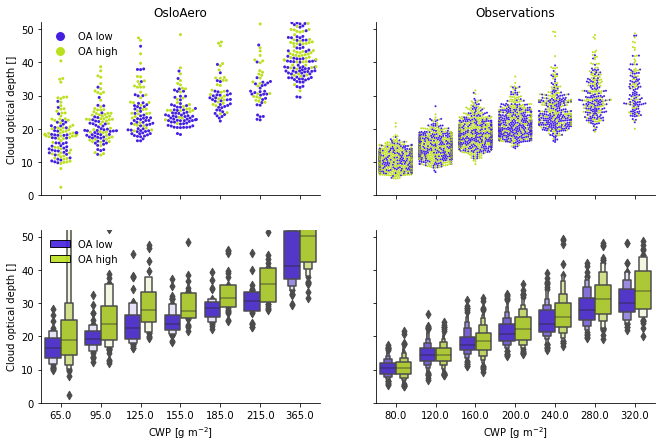

In [65]:
x_mod = 'CWP_cutl'
x_obs = 'CWP_cutl'
y_mod = 'TOT_ICLD_VISTAU_s'
y_obs = 'COT'
ylim = [0,52]
figsize = [12,10]
figsize = [11,7]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex='col')

markersize= 2

_df_obs = df_hyy_1#df_mod[df_mod['OA_category'].notna()].reset_index()
_df_obs_lim =_df_obs[(_df_obs[y_obs]<=ylim[1])& (_df_obs[y_obs]>=ylim[0])]


ax = axs[0,1]
sns.swarmplot(
    x=x_obs,
    y=y_obs,
    data=_df_obs_lim,
    hue_order=hue_order,
    hue='OA_category',
    palette=_palette,
    size = markersize,
    ax = ax,
)


ax = axs[1,1]
sns.boxenplot(
    x=x_obs,
    y=y_obs,
    data= _df_obs,
    hue_order=hue_order,#['OA low','OA high'],
    hue='OA_category',
    #kind='boxen',
    ax = ax,
    palette=_palette,
           )


## PLOT MODEL



_df_mod = df_mod[df_mod['OA_category'].notna()].reset_index()
_df_mod_lim =_df_mod[(_df_mod[y_mod]<=ylim[1])& (_df_mod[y_mod]>=ylim[0])]

markersize=3
ax = axs[0,0]
sns.swarmplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod_lim,
    hue_order=hue_order,

    hue='OA_category',
    palette=_palette,
    ax = ax,
    size = markersize,
)


ax = axs[1,0]
sns.boxenplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod,
    hue_order=hue_order,

    ax = ax,
    hue='OA_category',
    palette=_palette,
)


## ADJUSTMENTS

leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label='OA low'),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label='OA high'),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label='OA low'
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label='OA high'
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)


for ax in axs[:,1]:
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)
for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)


axs[0,0].set_title('OsloAero')
axs[0,1].set_title('Observations')

sns.despine(fig)

fn = make_fn(case_name, x_mod,y_mod, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 65.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 54.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


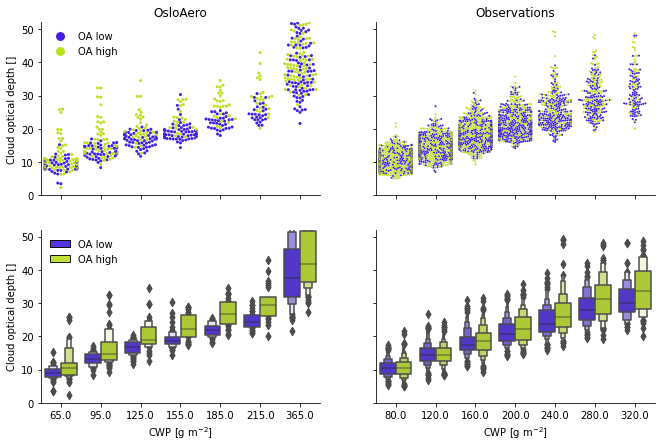

In [66]:
x_mod = 'CWP_cutl'
x_obs = 'CWP_cutl'
y_mod = 'TOT_CLD_VISTAU_s'
y_obs = 'COT'
ylim = [0,52]
figsize = [12,10]
figsize = [11,7]

_palette = palette_OA_2

fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex='col')


markersize= 2

_df_obs = df_hyy_1#df_mod[df_mod['OA_category'].notna()].reset_index()
_df_obs_lim =_df_obs[(_df_obs[y_obs]<=ylim[1])& (_df_obs[y_obs]>=ylim[0])]


ax = axs[0,1]
sns.swarmplot(
    x=x_obs,
    y=y_obs,
    data=_df_obs_lim,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    palette=_palette,
    size = markersize,
    ax = ax,
)


ax = axs[1,1]
sns.boxenplot(
    x=x_obs,
    y=y_obs,
    data= _df_obs,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    #kind='boxen',
    ax = ax,
    palette=_palette,
           )


## PLOT MODEL



_df_mod = df_mod[df_mod['OA_category'].notna()].reset_index()
_df_mod_lim =_df_mod[(_df_mod[y_mod]<=ylim[1])& (_df_mod[y_mod]>=ylim[0])]

markersize=3
ax = axs[0,0]
sns.swarmplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod_lim,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    palette=_palette,
    ax = ax,
    size = markersize,
)


ax = axs[1,0]
sns.boxenplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod,
    hue_order=['OA low','OA high'],
    ax = ax,
    hue='OA_category',
    palette=_palette,
)


## ADJUSTMENTS

leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label='OA low'),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label='OA high'),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label='OA low'
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label='OA high'
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)


for ax in axs[:,1]:
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)
for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)

axs[0,0].set_title('OsloAero')
axs[0,1].set_title('Observations')


sns.despine(fig)

fn = make_fn(case_name, x_mod,y_mod, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


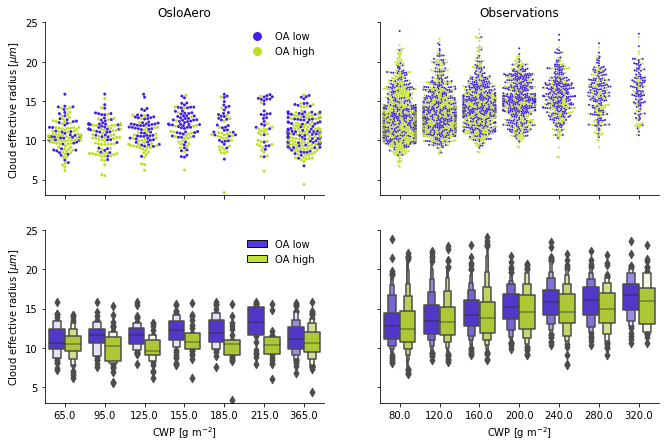

In [67]:
x_mod = 'CWP_cutl'
x_obs = 'CWP_cutl'
y_mod = 'ACTREL_incld'
y_obs = 'CER (micrometer)'
ylim = [3,25]
figsize = [11,7]
_palette = palette_OA_2
fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex='col')

markersize= 2

_df_obs = df_hyy_1#df_mod[df_mod['OA_category'].notna()].reset_index()
_df_obs_lim =_df_obs[(_df_obs[y_obs]<=ylim[1])& (_df_obs[y_obs]>=ylim[0])]




_df_mod = df_mod[df_mod['OA_category'].notna()].reset_index()
_df_mod_lim =_df_mod[(_df_mod[y_mod]<=ylim[1])& (_df_mod[y_mod]>=ylim[0])]



# OBSERVATIONS PLOT

ax = axs[0,1]
sns.swarmplot(
    x=x_obs,
    y=y_obs,
    data=_df_obs_lim,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    palette=_palette,
    size = markersize,
    ax = ax,
)


ax = axs[1,1]
sns.boxenplot(
    x=x_obs,
    y=y_obs,
    data= _df_obs,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    #kind='boxen',
    ax = ax,
    palette=_palette,
           )


## PLOT MODEL

markersize=3
ax = axs[0,0]
sns.swarmplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod_lim,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    palette=_palette,
    ax = ax,
    size = markersize,
)


ax = axs[1,0]
sns.boxenplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod,
    hue_order=['OA low','OA high'],
    ax = ax,
    hue='OA_category',
    palette=_palette,
)


## ADJUSTMENTS

leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label='OA low'),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label='OA high'),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label='OA low'
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label='OA high'
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)


for ax in axs[:,1]:
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)
for ax in axs[:,0]:
    ax.set_ylabel('Cloud effective radius [$\mu m$]')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)


axs[0,0].set_title('OsloAero')
axs[0,1].set_title('Observations')

sns.despine(fig)

fn = make_fn(case_name, x_mod,y_mod, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


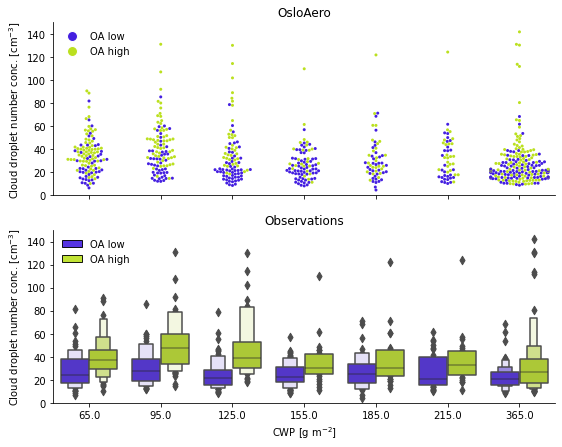

In [68]:
x_mod = 'CWP_cutl'
y_mod = 'ACTNL_incld'
ylim = [0,150]
figsize = [9,7]
_palette = palette_OA_2

fig, axs = plt.subplots(2,1,figsize=figsize, sharey=True, sharex='col')

markersize= 2

_df_obs = df_hyy_1
_df_obs_lim =_df_obs[(_df_obs[y_obs]<=ylim[1])& (_df_obs[y_obs]>=ylim[0])]

_df_mod = df_mod[df_mod['OA_category'].notna()].reset_index()
_df_mod_lim =_df_mod[(_df_mod[y_mod]<=ylim[1])& (_df_mod[y_mod]>=ylim[0])]



## PLOT MODEL

markersize=3
ax = axs[0]
sns.swarmplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod_lim,
    hue_order=['OA low','OA high'],
    hue='OA_category',
    palette=_palette,
    ax = ax,
    size = markersize,
)


ax = axs[1]
sns.boxenplot(
    x=x_mod,
    y=y_mod,
    data=_df_mod,
    hue_order=['OA low','OA high'],
    ax = ax,
    hue='OA_category',
    palette=_palette,
)


## ADJUSTMENTS

leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label='OA low'),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label='OA high'),
          ]
axs[1].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label='OA low'
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label='OA high'
           ),
          ]
axs[0].legend(handles = leg_els, frameon=False)


#for ax in axs[:,1]:
#    ax.legend([],[], frameon=False)
#    ax.set_ylabel(None)
for ax in axs:
    ax.set_ylabel(r'Cloud droplet number conc. [cm$^{-3}$]')
for ax in axs:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[:-1]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)

axs[0].set_title('OsloAero')
axs[1].set_title('Observations')


sns.despine(fig)

fn = make_fn(case_name, x_mod,y_mod, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg